# Description
---

This notebook can be used to reproduce results form the paper:
"Cross-column DFT-based QSRR model development powered by Machine Learning".

Data (molecular descriptors, column characteristics, and experimental retention times) are loaded, split into training, validation and blind test. QSRR models are built using four ML methods (Ridge Regression, Partial Least Squares, Random Forests and Gradient Boosting). Hyperparameters of the ML QSRR models are optimized using a grid search.

# Requirements
---

1. jupyter
2. notebook
3. numpy
4. pandas
5. matplotlib
6. seaborn
7. scikit-learn
8. shap

# Imports
---

In [1]:
# Install requirements
%pip install numpy pandas matplotlib seaborn scikit-learn shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy
from typing import (
    Any,
    Dict,
    List
)

import numpy as np
from numpy import ndarray

import pandas as pd
from pandas import DataFrame

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    cross_val_score,
    KFold,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    PredefinedSplit,
    train_test_split
)

from src.analysis import analyze_model
from src.config import (
    plot_settings,
    split_indices
)
from src.visuals import Visualizer

plt.rcParams.update(plot_settings)

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Loading & Processing
---

In [3]:
# Load Data
_data_df: DataFrame = pd.read_csv(
    './data/2023-07-19-qsrr_dataset.csv'
)

# Drop columns= 'name' and '#', 'ID', "Length"
_data_df.drop(
    columns=['#','name', 'ID', "Length"],
    errors="ignore",
    inplace=True
)

# Display Data
display(_data_df.head())

,SE[kcal/mol],Delta(min)[eV],M(tot.)[D],EnergyGap[eV],Electrophilicity[eV],IP[eV],EA[eV],GlobalHardness[eV],Electronegativity[eV],Electrophilicity [eV],Temperature,Gradient,ParticleSize,Carbon Load,PoreSize,TR
0,-7.440,-0.503,5.3780,8.383,-3.93,8.12,-0.26,4.19,3.93,1.84,25,40,2.7,10,120,15.842
1,-6.145,-0.545,1.7540,7.810,-3.61,7.51,-0.30,3.90,3.61,1.67,25,40,2.7,10,120,30.996
2,-7.669,-0.679,2.4686,8.287,-3.68,7.82,-0.46,4.14,3.68,1.63,25,40,2.7,10,120,12.111
3,-9.395,-0.666,6.9915,9.167,-4.07,8.65,-0.52,4.58,4.07,1.81,25,40,2.7,10,120,4.968
4,-12.792,-0.680,3.8255,7.723,-2.63,6.49,-1.23,3.86,2.63,0.90,25,40,2.7,10,120,12.465


# Data Analysis
---

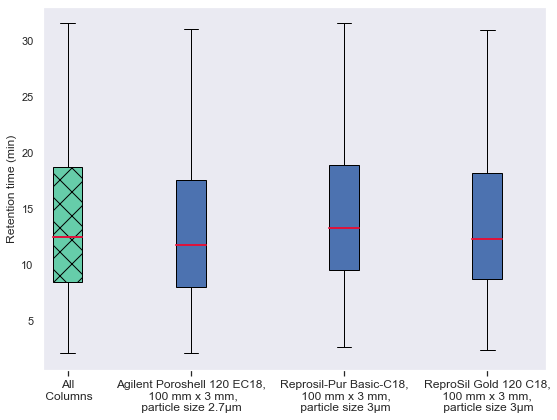

In [4]:
# Retention Times Boxplot

_x: List[Any] = [
    _data_df['TR'],
    _data_df['TR'][_data_df['Carbon Load'] == 10],  # Column 1
    _data_df['TR'][_data_df['Carbon Load'] == 17],  # Column 2
    _data_df['TR'][_data_df['Carbon Load'] == 20]
]

_positions: List[int] = [5, 30, 61, 90]

_labels: List[str] = [
    'All\n Columns',
    'Agilent Poroshell 120 EC18,\n 100 mm x 3 mm,\n particle size 2.7μm ',
    'Reprosil-Pur Basic-C18,\n 100 mm x 3 mm,\n particle size 3μm',
    'ReproSil Gold 120 C18,\n 100 mm x 3 mm, \n particle size 3μm'
]

_y_label: str = 'Retention time (min)'

Visualizer.boxplot(
    x=_x,
    positions=_positions,
    labels=_labels,
    y_label=_y_label
)

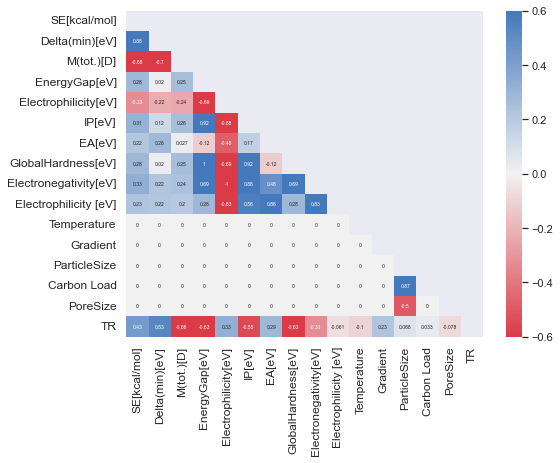

In [5]:
# Correlation Matrix Plot
_correlation_df = _data_df.corr(method='spearman')

Visualizer.correlation_heatmap(
    _correlation_df
)

# Train/Test Split

In [6]:
# X- and y- data
_x: ndarray = _data_df.iloc[:,:-1].values  # Variables -> x1 to x15
_y: ndarray = _data_df.iloc[:,-1].values   # Target: -> tR : retention tiime

# Split initial data into training & blind test sets
_x_train_all, _x_bt, _y_train_all, _y_bt = train_test_split(
    _x,
    _y,
    test_size=0.3
    ,shuffle=True,
    random_state=12345  # For reproducibility
)

# Split the training data further into training and validation
_x_train, _x_validation, _y_train, _y_validation = train_test_split(
    _x_train_all,
    _y_train_all,
    test_size=0.3,
    random_state=12345   # For reproducibility
)

# Summary
print('X-train:', _x_train.shape)
print('y-train:', _y_train.shape)
print('- - '*10)
print('X-validation:', _x_validation.shape)
print('y-validation:', _y_validation.shape)
print('- - '*10)
print('X-BT:', _x_bt.shape)
print('y-BT:', _y_bt.shape)
print('- - '*10)

# Using Predefiend Set of data for validation for hyper-parameter optimization
ps = PredefinedSplit(test_fold=split_indices)

X-train: (176, 15)
y-train: (176,)
- - - - - - - - - - - - - - - - - - - - 
X-validation: (76, 15)
y-validation: (76,)
- - - - - - - - - - - - - - - - - - - - 
X-BT: (108, 15)
y-BT: (108,)
- - - - - - - - - - - - - - - - - - - - 


# Hyper-Parameter Optimization, QSRR model building & analysis
---

## Random Forests
---

In [7]:
# RFs parameter grid
_rfs_param_grid: Dict[str, Any] = {
    'n_estimators': range(10, 210, 10),
    'max_features': [None, 'sqrt'],
    'max_depth': range(2, 30, 3),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'bootstrap': [True, False]
}

In [8]:
# Instantiate model
_rfs_model: GridSearchCV = GridSearchCV(
    estimator=RandomForestRegressor(random_state=12345),
    param_grid=_rfs_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=ps,
    n_jobs=20,
    verbose=10,
    refit=True
)

In [9]:
# Fit model
_rfs_model.fit(
    deepcopy(_x_train_all),  # Use all, because we extracted the validation indices previously for reproducibility
    deepcopy(_y_train_all)   # Use all, because we extracted the validation indices previously for reproducibility
)

Fitting 1 folds for each of 7200 candidates, totalling 7200 fits
[CV 1/1; 11/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=110
[CV 1/1; 11/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=110;, score=-3.247 total time=   0.4s
[CV 1/1; 43/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=30
[CV 1/1; 43/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=30;, score=-3.224 total time=   0.1s
[CV 1/1; 49/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=90
[CV 1/1; 49/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=90;, score=-3.235 total time=   0.3s
[CV 1/1; 62/7200] START bootstrap=True, max_depth=2, max_fe

[CV 1/1; 848/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=80;, score=-1.109 total time=   0.3s
[CV 1/1; 863/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=30
[CV 1/1; 863/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=30;, score=-1.126 total time=   0.2s
[CV 1/1; 870/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100
[CV 1/1; 870/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=-1.094 total time=   0.4s
[CV 1/1; 888/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=80
[CV 1/1; 888/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estima

[CV 1/1; 825/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=50
[CV 1/1; 825/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=50;, score=-0.966 total time=   0.2s
[CV 1/1; 836/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=160
[CV 1/1; 836/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=160;, score=-0.973 total time=   0.7s
[CV 1/1; 865/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50
[CV 1/1; 865/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=-1.102 total time=   0.2s
[CV 1/1; 877/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=5, n_es

[CV 1/1; 1011/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=110
[CV 1/1; 1011/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=110;, score=-2.061 total time=   0.4s
[CV 1/1; 1032/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=120
[CV 1/1; 1032/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=120;, score=-2.257 total time=   0.4s
[CV 1/1; 1054/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=140
[CV 1/1; 1054/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=140;, score=-2.290 total time=   0.5s
[CV 1/1; 1082/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_spl

[CV 1/1; 390/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=-0.867 total time=   0.4s
[CV 1/1; 409/7200] START bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=90
[CV 1/1; 409/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=90;, score=-1.032 total time=   0.4s
[CV 1/1; 427/7200] START bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=70
[CV 1/1; 5/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 1/1; 5/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=-3.259 total time=   0.3s
[CV 1/1; 31/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators

[CV 1/1; 623/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=30;, score=-2.171 total time=   0.1s
[CV 1/1; 629/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=90
[CV 1/1; 629/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=90;, score=-2.281 total time=   0.4s
[CV 1/1; 649/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=90
[CV 1/1; 649/7200] qrt, min_samples_leaf=3, min_samples_split=2, n_estimators=40
[CV 1/1; 244/7200] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=40;, score=-3.561 total time=   0.1s
[CV 1/1; 252/7200] START bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=120
[CV 1/1; 252/7200] END bootstrap=True, ma

[CV 1/1; 578/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=180
[CV 1/1; 578/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=180;, score=-1.926 total time=   0.7s
[CV 1/1; 610/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100
[CV 1/1; 610/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=-2.247 total time=   0.4s
[CV 1/1; 627/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=70
[CV 1/1; 627/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=70;, score=-2.273 total time=   0.3s
[CV 1/1; 641/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_est

[CV 1/1; 138/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=180;, score=-3.233 total time=   0.6s
[CV 1/1; 168/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=80
[CV 1/1; 168/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=80;, score=-3.238 total time=   0.3s
[CV 1/1; 183/7200] START bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=30
[CV 1/1; 183/7200] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=30;, score=-3.491 total time=   0.1s
[CV 1/1; 191/7200] START bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=110
[CV 1/1; 191/7200] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estima

[CV 1/1; 1050/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=-2.221 total time=   0.4s
[CV 1/1; 1067/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=70
[CV 1/1; 1067/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=70;, score=-2.168 total time=   0.3s
[CV 1/1; 1080/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=200
[CV 1/1; 1080/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=-2.220 total time=   0.7s
[CV 1/1; 8/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 1/1; 8/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_es

[CV 1/1; 668/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=80;, score=-2.401 total time=   0.3s
[CV 1/1; 684/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=40
[CV 1/1; 684/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=40;, score=-2.382 total time=   0.2s
[CV 1/1; 694/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=140
[CV 1/1; 694/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=140;, score=-2.423 total time=   0.5s
[CV 1/1; 717/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=170
[CV 1/1; 717/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estim

[CV 1/1; 620/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=-2.161 total time=   0.8s
[CV 1/1; 655/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 1/1; 655/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=-2.319 total time=   0.6s
[CV 1/1; 683/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=30
[CV 1/1; 683/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=30;, score=-2.342 total time=   0.1s
[CV 1/1; 690/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=100
[CV 1/1; 690/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_esti

[CV 1/1; 1066/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=60;, score=-2.104 total time=   0.2s
[CV 1/1; 1079/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=190
[CV 1/1; 1079/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=190;, score=-2.239 total time=   0.7s
[CV 1/1; 1111/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimaes=None, min_samples_leaf=3, min_samples_split=5, n_estimators=180
[CV 1/1; 458/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=180;, score=-0.931 total time=   0.8s
[CV 1/1; 491/7200] START bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=110
[CV 1/1; 491/7200] END bootstrap=True, max_depth=5, m

[CV 1/1; 783/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=30;, score=-0.866 total time=   0.1s
[CV 1/1; 790/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100
[CV 1/1; 790/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=-0.820 total time=   0.4s
[CV 1/1; 808/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=80
[CV [CV 1/1; 964/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=40
[CV 1/1; 964/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=40;, score=-2.108 total time=   0.2s
[CV 1/1; 972/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_es

[CV 1/1; 1757/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=170;, score=-2.242 total time=   0.3s
[CV 1/1; 1772/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=120
[CV 1/1; 1772/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=120;, score=-2.257 total time=   0.2s
[CV 1/1; 1781/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=10
[CV 1/1; 1781/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=-1.729 total time=   0.0s
[CV 1/1; 1782/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=20
[CV 1/1; 1782/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_s

[CV 1/1; 1295/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150;, score=-1.644 total time=   0.6s
[CV 1/1; 1323/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=30
[CV 1/1; 1323/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=30;, score=-2.077 total time=   0.1s
[CV 1/1; 1329/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=90
[C 621/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=10
[CV 1/1; 621/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=10;, score=-2.400 total time=   0.1s
[CV 1/1; 624/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estim

[CV 1/1; 1312/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=120
[CV 1/1; 1312/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=120;, score=-2.059 total time=   0.5s
[CV 1/1; 1335/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 1/1; 1335/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, nin_samples_leaf=3, min_samples_split=2, n_estimators=20;, score=-2.310 total time=   0.1s
[CV 1/1; 967/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=70
[CV 1/1; 967/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=70;, score=-2.112 total time=   0.3s
[CV 1/1; 980/7200] START bootstrap=True, max_depth=8, max_features=sqr

[CV 1/1; 1640/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-1.421 total time=   0.6s
[CV 1/1; 1663/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30
[CV 1/1; 1663/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30;, score=-1.782 total time=   0.1s
[CV 1/1; 1668/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80
[CV 1/1; 1668/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=-1.982 total time=   0.2s
[CV 1/1; 1674/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=140
[CV 1/1; 1674/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_

[CV 1/1; 1692/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=120
[CV 1/1; 1692/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=120;, score=-2.068 total time=   0.3s
[CV 1/1; 1700/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200
[CV 1/1; 1700/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=-2.006 total time=   0.4s
[CV 1/1; 1721/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=10
[CV 1/1; 1721/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=10;, score=-1.670 total time=   0.0s
[CV 1/1; 1722/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples

[CV 1/1; 1558/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=180
[CV 1/1; 1558/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=180;, score=-0.971 total time=   0.8s
[CV 1/1; 1591/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=110
[CV 1/1; 1591/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=_split=10, n_estimators=100
[CV 1/1; 1190/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=100;, score=-0.965 total time=   0.4s
[CV 1/1; 1212/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=120
[CV 1/1; 1212/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=2,

[CV 1/1; 1793/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=130
[CV 1/1; 1793/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=130;, score=-2.275 total time=   0.2s
[CV 1/1; 1804/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=40
[CV 1/1; 1804/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=-0.503 total time=   0.1s
[CV 1/1; 1809/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=90
[CV 1/1; 1809/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=90;, score=-0.491 total time=   0.2s
[CV 1/1; 1818/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_s

[CV 1/1; 1726/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=60;, score=-1.931 total time=   0.1s
[CV 1/1; 1732/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=120
[CV 1/1; 1732/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=120;, score=-2.078 total time=   0.3s
[CV 1/1; 1744/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=40
[CV 1/1; 1744/7200] END 4, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100
[CV 1/1; 1790/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=-2.221 total time=   0.2s
[CV 1/1; 1799/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=19

[CV 1/1; 1896/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=160
[CV 1/1; 1896/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=160;, score=-0.838 total time=   0.5s
[CV 1/1; 1915/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 1/1; 1915/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=-0.968 total time=   0.4s
[CV 1/1; 1932/7200] START bootstrap=True, mmin_samples_leaf=3, min_samples_split=5, n_estimators=190
[CV 1/1; 1899/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=190;, score=-0.830 total time=   0.5s
[CV 1/1; 1921/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=10
[CV 

[CV 1/1; 1495/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=-0.967 total time=   0.6s
[CV 1/1; 1518/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=180
[CV 1/1; 1518/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=180;, score=-0.832 total time=   0.8s
[CV 1/1; 1552/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=120
[CV 1/1; 1552/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=120;, score=-0.965 total time=   0.6s
[CV 1/1; 1573/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=130
[CV 1/1; 1573/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_sample

[CV 1/1; 2030/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 1/1; 2030/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=-2.031 total time=   0.3s
[CV 1/1; 2040/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200
[CV 1/1; 2040/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-1.984 total time=   0.5s
[CV 1/1; 2063/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=30
[CV 1/1; 2063/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=30;, score=-2.077 total time=   0.1s
[CV 1/1; 2067/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_sampl

[CV 1/1; 1783/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=30;, score=-2.011 total time=   0.1s
[CV 1/1; 1786/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=60
[CV 1/1; 1786/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=60;, score=-2.104 total time=   0.1s
[CV 1/1; 1796/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=160
[CV 1/1; 1796/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=160;, score=-2.280 total time=   0.3s
[CV 1/1; 1808/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 1/1; 1808/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_

[CV 1/1; 2199/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=190;, score=-0.671 total time=   0.3s
[CV 1/1; 2210/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 1/1; 2210/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=-0.982 total time=   0.3s
[CV 1/1; 2224/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=40
[CV 1/1; 2224/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=40;, score=-0.821 total time=   0.1s
[CV 1/1; 2230/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100
[CV 1/1; 2230/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_s

[CV 1/1; 1568/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=80
[CV 1/1; 1568/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=80;, score=-1.109 total time=   0.4s
[CV 1/1; 1584/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=40
[CV 1/1; 1584/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=40;, sctal time=   1.0s
[CV 1/1; 1619/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=190
[CV 1/1; 1619/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=190;, score=-1.099 total time=   0.7s
[CV 1/1; 1645/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_est

[CV 1/1; 2269/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=90
[CV 1/1; 2269/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=90;, score=-0.966 total time=   0.2s
[CV 1/1; 2277/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=170
[CV 1/1; 2277/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=170;, score=-0.972 total time=   0.4s
[CV 1/1; 2292/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=120
[CV 1/1; 2292/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=120;, score=-1.095 total time=   0.3s
[CV 1/1; 2301/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_sampl

[CV 1/1; 1383/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=30;, score=-2.011 total time=   0.1s
[CV 1/1; 1389/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=90
[CV 1/1; 1389/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=90;, score=-2.234 total time=   0.4s
[CV 1/1; 1408/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=80
in_samples_leaf=1, min_samples_split=10, n_estimators=10
[CV 1/1; 1841/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=-1.016 total time=   0.0s
[CV 1/1; 1842/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=20
[CV 1/1; 1842/7200] END bootstrap=True, max_depth=17,

[CV 1/1; 2039/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=190
[CV 1/1; 2039/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=190;, score=-2.004 total time=   0.5s
[CV 1/1; 2060/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200
[CV 1/1; 2060/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=-2.006 total time=   0.5s
[CV 1/1; 2082/7200] STA[CV 1/1; 1840/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.669 total time=   0.5s
[CV 1/1; 1860/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200
[CV 1/1; 1860/7200] END bootstrap=True, max_depth=17, max_features=None, min_sam

[CV 1/1; 1939/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=190
[CV 1/1; 1939/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=190;, score=-1.099 total time=   0.5s
[CV 1/1; 1961/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10
[CV 1/1; 1961/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=-1.242 total time=   0.0s
[CV 1/1; 1963/7200] START bootstrap=True, ma[CV 1/1; 1875/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=-0.832 total time=   0.4s
[CV 1/1; 1893/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=130
[CV 1/1; 1893/7200] END bootstrap=True, max_depth=17, max_feat

[CV 1/1; 2016/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=160
[CV 1/1; 2016/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=160;, score=-1.624 total time=   0.4s
[CV 1/1; 2035/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 1/1; 2035/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=-2.060 total time=   0.4s
[CV 1/1; 2052/7200] START bootstrap=True, max_depth=17, max_features[CV 1/1; 2195/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150;, score=-0.670 total time=   0.3s
[CV 1/1; 2206/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=60
[CV 1/1; 2206/7200] END bootstrap=Tr

[CV 1/1; 2317/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=170
[CV 1/1; 2317/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=170;, score=-1.095 total time=   0.4s
[CV 1/1; 2333/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=130
[CV 1/1; 2333/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=1=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=120
[CV 1/1; 2052/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=120;, score=-2.068 total time=   0.3s
[CV 1/1; 2066/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=60
[CV 1/1; 2066/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_

[CV 1/1; 2818/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=180
[CV 1/1; 2818/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=180;, score=-2.032 total time=   0.4s
[CV 1/1; 2836/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=160
[CV 1/1; 2836/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=160;, score=-2.280 total time=   0.4s
[CV 1/1; 2854/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=140
split=10, n_estimators=110;, score=-2.061 total time=   0.3s
[CV 1/1; 2104/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=40
[CV 1/1; 2104/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min

[CV 1/1; 2113/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=130;, score=-2.275 total time=   0.3s
[CV 1/1; 2126/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=60
[CV 1/1; 2126/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=60;, score=-2.104 total time=   0.1s
[CV 1/1; 2133/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=130
[CV 1/1; 2133/7200] END bootstrap=True, max_depth=170] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=110
[CV 1/1; 2731/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=110;, score=-1.629 total time=   0.2s
[CV 1/1; 2741/7200] START bootstrap=True, max_depth=23, max_features=sqrt

[CV 1/1; 2579/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=190;, score=-0.971 total time=   0.5s
[CV 1/1; 2599/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=190
[CV 1/1; 2599/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=190;, score=-0.830 total time=   0.5s
[CV 1/1; 2618/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=180
[CV 1/1; 2618/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=180;, score=-0.832 total time=   0.5s
[CV 1/1; 2637/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=170
[CV 1/1; 2637/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples

[CV 1/1; 2218/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=180;, score=-0.973 total time=   0.5s
[CV 1/1; 2236/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=160
[CV 1/1; 2236/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=160;, score=-0.838 total time=   0.4s
[CV 1/1; 2252/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf_samples_leaf=1, min_samples_split=2, n_estimators=140
[CV 1/1; 2534/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=140;, score=-0.493 total time=   0.4s
[CV 1/1; 2548/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 1/1; 2548/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, 

[CV 1/1; 2990/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=100;, score=-0.965 total time=   0.3s
[CV 1/1; 2999/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=190
[CV 1/1; 2999/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=190;, score=-0.970 total time=   0.4s
[CV 1/1; 3016/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=160
[CV 1/1; 3016/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=160;, score=-1.100 total time=   0.4s
[CV 1/1; 3031/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=110
[CV 1/1; 3031/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_sample

[CV 1/1; 3157/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=170;, score=-2.038 total time=   0.5s
[CV 1/1; 3176/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=160
[CV 1/1; 3176/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=160;, score=-2.090 total time=   0.4s
[CV 1/1; 3193/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=130
[CV 1/1; 3193/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=130;, score=-2.275 total time=   0.4s
[CV 1/1; 3207/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=70
[CV 1/1; 3207/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=5, min_samples_

[CV 1/1; 2339/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=190;, score=-1.099 total time=   0.4s
[CV 1/1; 2356/7200] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160
[CV 1/1; 2356/7200] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160;, score=-1.491 total time=   0.3s
[CV 1/1; 2370/7200] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100
[CV 1/1; 2370/7200] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=-1.621 total time=   0.2s
[CV 1/1; 3191/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=110
[CV 1/1; 3191/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=5, min_samples_

[CV 1/1; 2611/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=110;, score=-0.820 total time=   0.3s
[CV 1/1; 2623/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=30
[CV 1/1; 2623/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=30;, score=-1.000 total time=   0.1s
[CV 1/1; 2625/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_sa[CV 1/1; 2728/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=-1.674 total time=   0.2s
[CV 1/1; 2737/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=170
[CV 1/1; 2737/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=170;, score=

[CV 1/1; 3027/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=70;, score=-1.090 total time=   0.2s
[CV 1/1; 3034/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=140
[CV 1/1; 3034/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=140;, score=-1.095 total time=   0.3s
[CV 1/1; 3047/7200] START bootstrap=True, max_depth=26, max_features=None, maf=3, min_samples_split=2, n_estimators=70
[CV 1/1; 2587/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=70;, score=-0.810 total time=   0.2s
[CV 1/1; 2592/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=120
[CV 1/1; 2592/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estima

[CV 1/1; 2615/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=150;, score=-0.832 total time=   0.4s
[CV 1/1; 2629/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=90
[CV 1/1; 2629/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=90;, score=-0.966 total time=   0.2s
[CV 1/1; 2640/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=200
[CV 1/1; 2640/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=-0.972 total time=   0.5s
[CV 1/1; 2660/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=200
[CV 1/1; 2660/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=5, min_samples

[CV 1/1; 3135/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=-2.094 total time=   0.3s
[CV 1/1; 3150/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=100
[CV 1/1; 3150/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=100;, score=-2.067 total time=   0.2s
[CV 1/1; 3160/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=200
[CV 1/1; 3160/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=200;, score=-2.006 total time=   0.6s
[CV 1/1; 3180/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200
[CV 1/1; 3180/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_

[CV 1/1; 2844/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=40
[CV 1/1; 2844/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=40;, score=-2.098 total time=   0.1s
[CV 1/1; 2848/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=80
[CV 1/1; 2848/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=-2.187 total time=   0.2s
[CV 1/1; 2856/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=160
[CV 1/1; 2856/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=160;, score=-2.280 total time=   0.4s
[CV 1/1; 2873/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_spl

[CV 1/1; 3187/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=70
[CV 1/1; 3187/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=70;, score=-2.168 total time=   0.2s
[CV 1/1; 3199/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=190
[CV 1/1; 3199/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=190;, score=-2.239 total time=   0.5s
[CV 1/1; 3220/7200] START bootstrap=True, max_depth=26, max_featuV 1/1; 3427/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70
[CV 1/1; 3427/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70;, score=-1.312 total time=   0.2s
[CV 1/1; 3434/7200] START bootstrap=True, max_d

[CV 1/1; 3784/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40
[CV 1/1; 3784/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=-3.643 total time=   0.1s
[CV 1/1; 3792/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120
[CV 1/1; 3792/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=-3.670 total time=   0.2s
[CV 1/1; 3803/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=30
[CV 1/1; 3803/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=30;, score=-3.608 total time=   0.1s
[CV 1/1; 3806/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_spl

[CV 1/1; 2998/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=180
[CV 1/1; 2998/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=180;, score=-0.971 total time=   0.4s
[CV 1/1; 3015/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=150
[CV 1/1; 3015/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=150;, score=-1.097 total time=   0.4s
[CV 1/1; 3028/7200] START bootstrap=True, rs=30;, score=-2.011 total time=   0.1s
[CV 1/1; 3186/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=60
[CV 1/1; 3186/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=60;, score=-2.104 total time=   0.2s
[CV 1/1; 3196/7200] STAR

[CV 1/1; 3313/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=130;, score=-0.833 total time=   0.4s
[CV 1/1; 3328/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=80
[CV 1/1; 3328/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=80;, score=-0.829 total time=   0.3s
[CV 1/1; 3337/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=170
[CV 1/1; 3337/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=170;, score=-0.835 total time=   0.6s
[CV 1/1; 3359/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=190
[CV 1/1; 3359/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_sp

[CV 1/1; 3899/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=190;, score=-3.628 total time=   0.3s
[CV 1/1; 3920/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=200
[CV 1/1; 3920/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=-3.630 total time=   0.3s
[CV 1/1; 3938/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=180
[CV 1/1; 3938/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=180;, score=-3.638 total time=   0.3s
[CV 1/1; 3957/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=170
[CV 1/1; 3957/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples

[CV 1/1; 3678/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=180;, score=-3.610 total time=   0.3s
[CV 1/1; 3695/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=150
[CV 1/1; 3695/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=150;, score=-3.610 total time=   0.2s
[CV 1/1; 3707/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=70
[CV 1/1; 3707/7200] END bootstrap=False, max_depth[CV 1/1; 3507/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=70;, score=-2.111 total time=   0.1s
[CV 1/1; 3513/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=130
[CV 1/1; 3513/7200] END bootstrap=True, max_depth=29, max

[CV 1/1; 3889/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=90;, score=-3.678 total time=   0.1s
[CV 1/1; 3898/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=180
[CV 1/1; 3898/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=180;, score=-3.638 total time=   0.3s
[CV 1/1; 3916/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=160
[CV 1/1; 3916/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=160;, score=-3.635 total time=   0.3s
[CV 1/1; 3933/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=130
[CV 1/1; 3933/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples

[CV 1/1; 3460/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-1.642 total time=   0.4s
[CV 1/1; 3786/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60
[CV 1/1; 3786/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60;, score=-3.624 total time=   0.1s
[CV 1/1; 3791/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2 3900/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200
[CV 1/1; 3900/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=-3.630 total time=   0.3s
[CV 1/1; 3919/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=190


[CV 1/1; 4401/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=10;, score=-0.790 total time=   0.0s
[CV 1/1; 4403/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=30
[CV 1/1; 4403/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=30;, score=-0.790 total time=   0.1s
[CV 1/1; 4406/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=60
[CV 1/1; 4406/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=60;, score=-0.790 total time=   0.1s
[CV 1/1; 4411/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=110
[CV 1/1; 4411/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=

[CV 1/1; 3691/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=110
[CV 1/1; 3691/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=110;, score=-3.610 total time=   0.2s
[CV 1/1; 3701/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=10
[CV 1/1; 3701/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=10;, score=-3.610 total time=   0.0s
[CV 1/1; 3702/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=20
[CV 1/1; 3702/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=20;, score=-3.610 total time=   0.0s
[CV 1/1; 3703/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples

[CV 1/1; 3537/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=170
[CV 1/1; 3537/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=170;, score=-2.048 total time=   0.3s
[CV 1/1; 3551/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=110
[CV 1/1; 3551/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samplesse, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=70;, score=-0.790 total time=   0.2s
[CV 1/1; 4412/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=120
[CV 1/1; 4412/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=120;, score=-0.790 total time=   0.2s
[CV 1/1; 4423/7200] START bootstrap=Fa

[CV 1/1; 3761/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10
[CV 1/1; 3761/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=-3.610 total time=   0.0s
[CV 1/1; 3762/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=20
[CV 1/1; 3762/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=20;, score=-3.610 toit=10, n_estimators=150;, score=-3.637 total time=   0.3s
[CV 1/1; 3912/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=120
[CV 1/1; 3912/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=120;, score=-3.670 total time=   0.2s
[CV 1/1; 3925/7200] START bootstrap=False, max_depth=2, max_featu

[CV 1/1; 4300/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=-2.235 total time=   0.2s
[CV 1/1; 4316/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=160
[CV 1/1; 4316/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=160;, score=-2.213 total time=   0.2s
[CV 1/1; 4330/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/1; 4330/7200] END bootstrap=False, max_depth=8, max_[CV 1/1; 3381/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=-1.242 total time=   0.0s
[CV 1/1; 3383/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=30
[CV 1/1; 3383/7200] END bootstrap=True, max_dept

[CV 1/1; 4036/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=160;, score=-1.006 total time=   0.3s
[CV 1/1; 4053/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=130
[CV 1/1; 4053/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=130;, score=-1.006 total time=   0.3s
[CV 1/1; 4067/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=70
[CV 1/1; 4067/7_samples_leaf=3, min_samples_split=2, n_estimators=170;, score=-3.610 total time=   0.3s
[CV 1/1; 3692/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=120
[CV 1/1; 3692/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=120;, score=-3.610 total time=   0.2s
[C

[CV 1/1; 3517/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=170
[CV 1/1; 3517/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=170;, score=-2.038 total time=   0.3s
[CV 1/1; 3532/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=120
[CV 1/1; 3532/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samplessplit=2, n_estimators=110;, score=-1.159 total time=   0.2s
[CV 1/1; 4102/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=20
[CV 1/1; 4102/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=20;, score=-1.159 total time=   0.0s
[CV 1/1; 4104/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_s

[CV 1/1; 4181/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10
[CV 1/1; 4181/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=-1.879 total time=   0.0s
[CV 1/1; 4182/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20
[CV 1/1; 4182/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20;, score=-1.904 total time=   0.0s
[CV 1/1; 4184/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40
[CV 1/1; 4184/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40;, score=-1.944 total time=   0.1s
[CV 1/1; 4188/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples

[CV 1/1; 4884/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=40
[CV 1/1; 4884/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=40;, score=-1.400 total time=   0.1s
[CV 1/1; 4887/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70
[CV 1/1; 4887/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70;, score=-1.485 total time=   0.1s
[CV 1/lit=10, n_estimators=120;, score=-1.608 total time=   0.2s
[CV 1/1; 4565/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50
[CV 1/1; 4565/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50;, score=-1.642 total time=   0.1s
[CV 1/1; 4570/7200] START bootstrap=False, 

[CV 1/1; 4601/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=10;, score=-2.142 total time=   0.0s
[CV 1/1; 4602/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20
[CV 1/1; 4602/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20;, score=-2.020 total time=   0.0s
[CV 1/1; 4605/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50
[CV 1/1; 4605/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_les_split=2, n_estimators=90
[CV 1/1; 3489/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=90;, score=-2.126 total time=   0.2s
[CV 1/1; 3496/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimato

[CV 1/1; 4636/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=160
[CV 1/1; 4636/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=160;, score=-1.974 total time=   0.3s
[CV 1/1; 4652/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=120
[CV 1/1; 4652/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=120;, score=-2.071 total time=   0.2s
[CV 1/1; 4666/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=60
[CV 1/1; 4666/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=60;, score=-2.106 total time=   0.1s
[CV 1/1; 4673/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples

[CV 1/1; 4103/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=30
[CV 1/1; 4103/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=30;, score=-1.159 total time=   0.1s
[CV 1/1; 4106/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=60
[CV 1/1; 4106/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=60;, score=-1.159 total time=   0.1s
[CV 1/1; 4112/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=120
[CV 1/1; 4112/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=120;, score=-1.159 total time=   0.2s
[CV 1/1; 4125/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_spl

[CV 1/1; 4856/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=160;, score=-1.034 total time=   0.2s
[CV 1/1; 4866/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60
[CV 1/1; 4866/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60;, score=-1.338 total time=   0.1s
[CV 1/1; 4871/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=110
[CV 1/1; 4871/7200] END bootstrap=False, max_depth=11, max_features=sq=   0.3s
[CV 1/1; 4678/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=180
[CV 1/1; 4678/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=180;, score=-1.984 total time=   0.3s
[CV 1/1; 4694/7200] ST

[CV 1/1; 5046/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=60;, score=-0.544 total time=   0.1s
[CV 1/1; 5053/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=130
[CV 1/1; 5053/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=130;, score=-0.545 total time=   0.3s
[CV 1/1; 5067/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=70
[CV 1/1; 5067/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=70;, score=-0.684 total time=   0.1s
[CV 1/1; 5075/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150
[CV 1/1; 5075/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_sampl

[CV 1/1; 4758/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=180
[CV 1/1; 4758/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=180;, score=-0.790 total time=   0.4s
[CV 1/1; 4776/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=160
[CV 1/1; 4776/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=160;, score=-0.790 total[CV 1/1; 4468/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=-1.034 total time=   0.2s
[CV 1/1; 4477/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=170
[CV 1/1; 4477/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=5, n_e

[CV 1/1; 4547/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=70;, score=-1.627 total time=   0.1s
[CV 1/1; 4555/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 1/1; 4555/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=-1.605 total time=   0.3s
[CV 1/1; 4571/7200] START bootstrap=False, max_depth=8, max_features=sqrt,plit=2, n_estimators=40
[CV 1/1; 5104/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=40;, score=-0.790 total time=   0.1s
[CV 1/1; 5109/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=90
[CV 1/1; 5109/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=90;, score=

[CV 1/1; 4962/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20
[CV 1/1; 4962/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20;, score=-2.018 total time=   0.0s
[CV 1/1; 4965/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50
[CV 1/1; 4965/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50;, score=-1.737 total time=   0.1s
[CV 1/mators=100;, score=-1.754 total time=   0.2s
[CV 1/1; 4620/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200
[CV 1/1; 4620/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=-1.678 total time=   0.3s
[CV 1/1; 4641/7200] START bootstrap=False, max_de

[CV 1/1; 5108/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=80;, score=-0.790 total time=   0.1s
[CV 1/1; 5112/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=120
[CV 1/1; 5112/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=120;, score=-0.790 total time=   0.2s
[CV 1/1; 5121/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=160;, score=-1.974 total time=   0.3s
[CV 1/1; 4692/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=120
[CV 1/1; 4692/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=-0.545 total time=   0.3s
[CV 1/1; 4705/

[CV 1/1; 5235/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=-1.334 total time=   0.3s
[CV 1/1; 5252/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=120
[CV 1/1; 5252/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=120;, score=-1.468 total time=   0.3s
[CV 1/1; 5266/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60
[CV 1/1; 5266/7200] END bootstrap=False, max_depth=14, max_featune, min_samples_leaf=1, min_samples_split=2, n_estimators=140;, score=-0.544 total time=   0.3s
[CV 1/1; 5069/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=90
[CV 1/1; 5069/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_s

[CV 1/1; 4948/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=80;, score=-1.669 total time=   0.1s
[CV 1/1; 4953/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=130
[CV 1/1; 4953/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=130;, score=-1.671 total time=   0.1s
[CV 1/1; 4959/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=190
[CV 1/1; 4959/7200] END bootstrap=False, max_depth=11, max_featureres=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60;, score=-1.645 total time=   0.1s
[CV 1/1; 5275/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 1/1; 5275/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_

[CV 1/1; 4782/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=20;, score=-0.945 total time=   0.0s
[CV 1/1; 4784/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=40
[CV 1/1; 4784/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=40;, score=-0.945 total time=   0.1s
[CV 1/1; 4788/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=80
[CV 1/1; 4788/7200] END bootstrap=False, max_dep, score=-0.945 total time=   0.1s
[CV 1/1; 5152/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=120
[CV 1/1; 5152/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=120;, score=-0.945 total time=   0.2s
[CV 1/1; 5164/72

[CV 1/1; 4734/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=140;, score=-0.944 total time=   0.3s
[CV 1/1; 4750/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100
[CV 1/1; 4750/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=-0.790 total time=   0.2s
[CV 1/1; 4759/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=190
[CV 1ples_split=2, n_estimators=50;, score=-0.790 total time=   0.1s
[CV 1/1; 5111/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=110
[CV 1/1; 5111/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=110;, score=-0.790 total time=   0.2s
[CV 1/1; 5125/7200] START boot

[CV 1/1; 4854/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=140
[CV 1/1; 4854/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=140;, score=-1.034 total time=   0.4s
[CV 1/1; 4874/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=140
[CV 1/1; 4874/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=140;, score=-1.339 total time=   0.3s
[CV 1/1; 4888/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 1/1; 4888/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=-1.507 total time=   0.1s
[CV 1/1; 4894/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_

[CV 1/1; 4742/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=20
[CV 1/1; 4742/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=20;, score=-0.790 total time=   0.1s
[CV 1/1; 4745/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=50
[CV 1/1; 4745/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=50;, score=-0.790 total time=   0.1s
[CV 1/1; 4752/7200] START bootstrap=False, max_depth=11,mators=130;, score=-1.034 total time=   0.3s
[CV 1/1; 5226/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60
[CV 1/1; 5226/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60;, score=-1.358 total time=   0.1s
[CV 1

[CV 1/1; 4764/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=40;, score=-0.790 total time=   0.1s
[CV 1/1; 4767/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=70
[CV 1/1; 4767/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=70;, score=-0.790 total time=   0.1s
[CV 1/1; 4774/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=140
[CV 1/1; 4774/7200] END bo/1; 4957/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=170;, score=-1.716 total time=   0.3s
[CV 1/1; 4979/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=190
[CV 1/1; 4979/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_sam

[CV 1/1; 5471/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=110;, score=-0.790 total time=   0.2s
[CV 1/1; 5477/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=170
[CV 1/1; 5477/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=170;, score=-0.790 total time=   0.3s
[CV 1/1; 5495/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=150
[CV 1/1; 5495/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=150;, score=-0.790 total time=   0.4s
[CV 1/1; 5515/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 1/1; 5515/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_s

[CV 1/1; 5627/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=70;, score=-1.660 total time=   0.1s
[CV 1/1; 5629/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90
[CV 1/1; 5629/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90;, score=-1.693 total time=   0.1s
[CV 1/1; 5637/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=170
[CV 1/1; 5637/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=170;, score=-1.600 total time=   0.2s
[CV 1/1; 5649/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=90
[CV 1/1; 5649/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_s

[CV 1/1; 4895/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150;, score=-1.473 total time=   0.2s
[CV 1/1; 4911/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=110
[CV 1/1; 4911/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=110;, score=-1.651 total time=   0.2s
[CV 1/1; 4922/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20
[CV 1/1; 4922/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20;, score=-1.666 total time=   0.0s
[CV 1/1; 4928/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=80
[CV 1/1; 4928/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_sam

[CV 1/1; 5289/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=90;, score=-1.671 total time=   0.2s
[CV 1/1; 5298/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=180
[CV 1/1; 5298/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=180;, score=-1.747 total time=   0.4s
[CV 1/1; 5314/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=140
[CV 1/1; 5314/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=140;, score=-1.682 total time=   0.2s
[CV 1/1; 5327/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=70
[CV 1/1; 5327/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_sam

[CV 1/1; 5563/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=30
[CV 1/1; 5563/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=30;, score=-1.034 total time=   0.1s
[CV 1/1; 5773/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=130
[CV 1/1; 5773/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=130;, score=-0.545 total time=   0.2s
[CV 1/1; 5781/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10
[CV 1/1; 5781/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=-0.684 total time=   0.0s
[CV 1/1; 5782/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_sa

[CV 1/1; 5459/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=190
[CV 1/1; 5459/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=190;, score=-0.944 total time=   0.4s
[CV 1/1; 5479/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=190
[CV 1/1; 5479/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_ssplit=5, n_estimators=130;, score=-0.684 total time=   0.3s
[CV 1/1; 5445/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50
[CV 1/1; 5445/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=-0.944 total time=   0.1s
[CV 1/1; 5449/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, m

[CV 1/1; 5867/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=70;, score=-0.945 total time=   0.1s
[CV 1/1; 5874/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=140
[CV 1/1; 5874/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=140;, score=-0.945 total time=   0.3s
[CV 1/1; 5890/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100
[CV 1/1; 5890/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=-1.034 total time=   0.2s
[CV 1/1; 5900/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=200
[CV 1/1; 5900/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=5, min_

[CV 1/1; 5509/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=90
[CV 1/1; 5509/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=90;, score=-0.945 total time=   0.2s
[CV 1/1; 5518/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=180
[CV 1/1; 5518/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=11.321 total time=   0.0s
[CV 1/1; 5945/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 1/1; 5945/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=-1.425 total time=   0.1s
[CV 1/1; 5951/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators

[CV 1/1; 6069/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=90
[CV 1/1; 6069/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=90;, score=-2.200 total time=   0.1s
[CV 1/1; 6076/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=160
[CV 1/1; 6076/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_e0, n_estimators=180;, score=-0.945 total time=   0.5s
[CV 1/1; 5541/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10
[CV 1/1; 5541/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=-1.034 total time=   0.0s
[CV 1/1; 5543/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, mi

[CV 1/1; 6070/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=-2.138 total time=   0.2s
[CV 1/1; 6078/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=180
[CV 1/1; 6078/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=180;, score=-1.992 total time=   0.3s
[CV 1/1; 6096/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=160
[CV 1/1; 6096/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=160;, score=-1.984 total time=   0.3s
[CV 1/1; 6113/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=130
[CV 1/1; 6113/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_s

[CV 1/1; 5376/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=160
[CV 1/1; 5376/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=160;, score=-1.984 total time=   0.2s
[CV 1/1; 5391/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=110
[CV 1/1; 5391/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_sne, min_samples_leaf=3, min_samples_split=2, n_estimators=110
[CV 1/1; 6191/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=110;, score=-0.790 total time=   0.2s
[CV 1/1; 6201/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=10
[CV 1/1; 6201/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=3, min

[CV 1/1; 6153/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=130;, score=-0.684 total time=   0.3s
[CV 1/1; 6165/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50
[CV 1/1; 6165/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=-0.944 total time=   0.1s
[CV 1/1; 6170/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 1/1; 6170/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=-0.944 total time=   0.2s
[CV 1/1; 6178/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=180
[CV 1/1; 6178/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min

[CV 1/1; 5843/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=30;, score=-0.790 total time=   0.1s
[CV 1/1; 5846/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=60
[CV 1/1; 5846/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=60;, score=-0.790 total time=   0.1s
[CV 1/1; 5852/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=120
[CV 1/1; 5852/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=120;, score=-0.790 total time=   0.3s
[CV 1/1; 5864/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=40
[CV 1/1; 5864/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=3, min_sampl

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=20,
             param_grid={'bootstrap': [True, False],
                         'max_depth': range(2, 30, 3),
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': range(10, 210, 10)},
             scoring='neg_root_mean_squared_error', verbose=10)

In [10]:
# Optimal Results
print(f"Optimal hyper-parameters : {_rfs_model.best_params_}")
print(f"Optimal RMSE : {-_rfs_model.best_score_.round(3)}")

# Optimal Model
_rfs_optimal_model: RandomForestRegressor = _rfs_model.best_estimator_

display(_rfs_optimal_model)

Optimal hyper-parameters : {'bootstrap': True, 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}
Optimal RMSE : 0.486


RandomForestRegressor(max_depth=11, max_features=None, n_estimators=70,
                      random_state=12345)

Results Analysis for : Random Forests


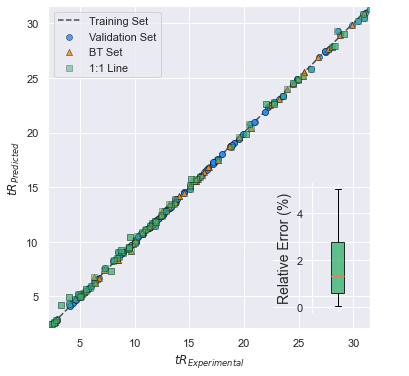

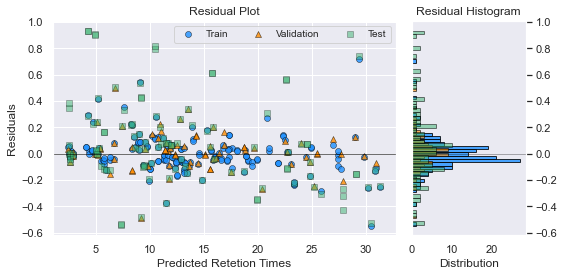

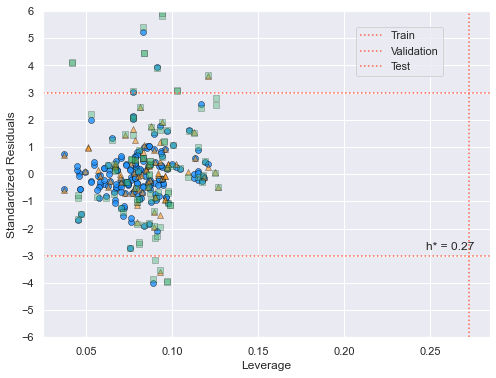

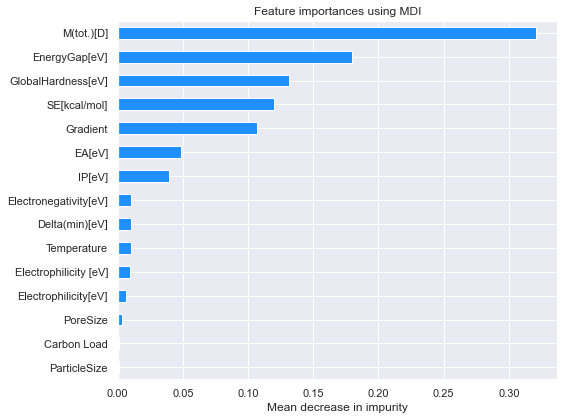

[CV 1/1; 6287/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=70;, score=-1.034 total time=   0.2s
[CV 1/1; 6295/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=150
[CV 1/1; 6295/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=150;, score=-1.034 total time=   0.4s
[CV 1/1; 6316/7200] START bootstrap=False, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160
[CV 1/1; 6316/7200] END bootstrap=False, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160;, score=-1.320 total time=   0.4s
[CV 1/1; 6336/7200] START bootstrap=False, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=160
[CV 1/1; 6336/7200] END bootstrap=False, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_

[CV 1/1; 7101/7200] END bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=10;, score=-1.664 total time=   0.0s
[CV 1/1; 7104/7200] START bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=40
[CV 1/1; 7104/7200] END bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=40;, score=-1.728 total time=   0.1s
[CV 1/1; 7107/7200] START bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=70
[CV 1/1; 7107/7200] END bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=70;, score=-1.726 total time=   0.1s
[CV 1/1; 7115/7200] START bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=150
[CV 1/1; 7115/7200] END bootstrap=False, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples

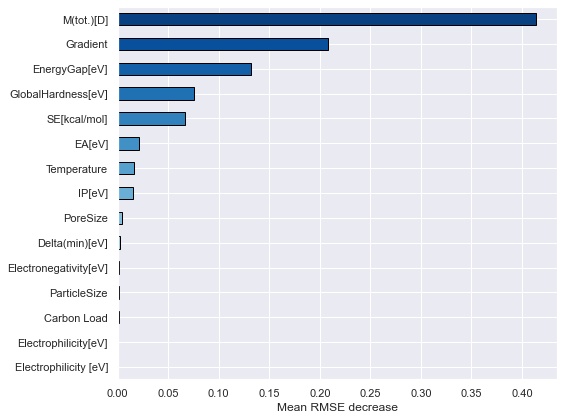

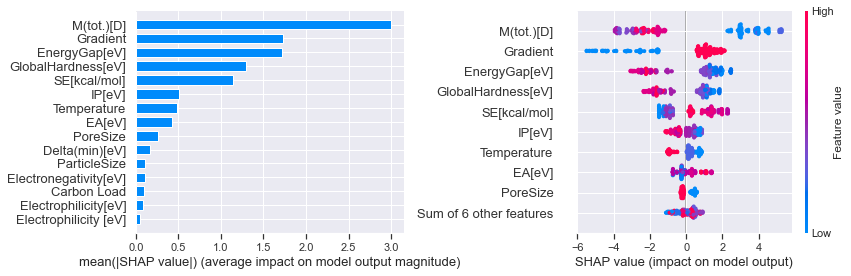

In [11]:
# Analyze results
_rf_predictions_df, _rf_metrics_df = analyze_model(
    model=_rfs_optimal_model,
    cv=ps,
    title="Random Forests",
    x_train=deepcopy(_x_train),
    y_train=deepcopy(_y_train.ravel()),
    x_validation=deepcopy(_x_validation),
    y_validation=deepcopy(_y_validation.ravel()),
    x_bt=deepcopy(_x_bt),
    y_bt=deepcopy(_y_bt.ravel()),
    x_train_all=deepcopy(_x_train_all),
    y_train_all=deepcopy(_y_train_all.ravel()),
    x_all=deepcopy(_x),
    y_all=deepcopy(_y.ravel()),
    column_names=np.array(list(_data_df.drop(columns=["TR"]).columns))
)

In [12]:
display(_rf_predictions_df)
display(_rf_metrics_df)

,0
r2_train,0.999637
rmse_train,0.137084
r2_validation,0.999636
rmse_validation,0.138655
r2_bt,0.998416
rmse_bt,0.329713


,y,y_hat,residuals,train_test,leverage,scaled_residuals
0,24.892,24.932920,0.040920,Train,0.093937,0.298519
1,17.206,17.239614,0.033614,Train,0.060857,0.245224
2,11.315,11.262481,-0.052519,Train,0.087276,-0.383139
3,31.065,30.954723,-0.110277,Train,0.080276,-0.804499
4,14.532,14.536954,0.004954,Train,0.045973,0.036142
...,...,...,...,...,...,...
355,4.968,4.991558,0.023558,BT,0.066822,0.171860
356,22.754,22.647169,-0.106831,BT,0.045584,-0.779358
357,10.271,10.554298,0.283298,BT,0.077291,2.066721
358,8.110,8.332403,0.222403,BT,0.097336,1.622480


##  Partial Least Squares
---

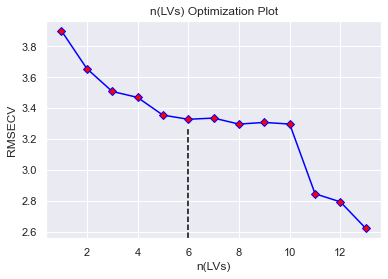

In [13]:
# Number of PLS components
_n_latent_variables: ndarray = np.array(range(1, 14, 1))

# Optimization of n(LVs)

_rmsecvs: List[float] = []

for _n_lvs in _n_latent_variables:

    _pls_model = make_pipeline(StandardScaler(), PLSRegression(n_components=_n_lvs))

    _cv = KFold(n_splits=10, shuffle=True, random_state=12345)

    _score = cross_val_score(
        _pls_model,
        deepcopy(_x_train),
        deepcopy(_y_train),
        scoring='neg_root_mean_squared_error',
        cv=_cv
    )

    _rmse = -_score.mean()
    
    _rmsecvs.append(_rmse)

_rmsecvs: ndarray = np.array(_rmsecvs)

Visualizer.latent_variable_plot(
    rmsecvs=_rmsecvs,
    latent_variables=_n_latent_variables,
    optimal_n_lvs=6,  # For reproducibility
    y_max=0.51  # For reproducibility
)

In [14]:
# Train PLS Model
_pls_optimal_model = make_pipeline(
    StandardScaler(),
    PLSRegression(n_components=6)
)

_pls_optimal_model.fit(
    deepcopy(_x_train),
    deepcopy(_y_train)
)

display(_pls_optimal_model)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('plsregression', PLSRegression(n_components=6))])

Results Analysis for : PLS


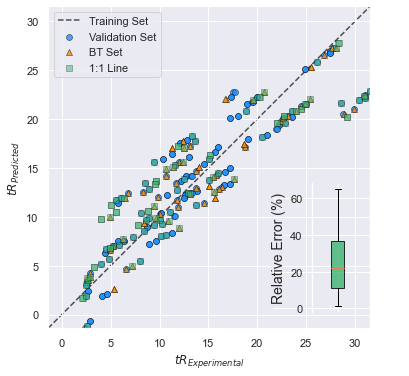

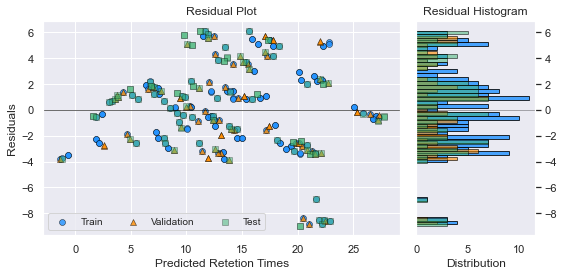

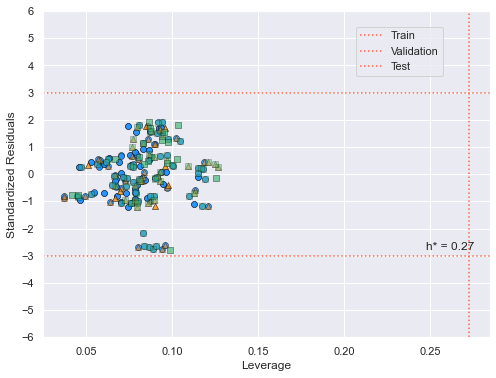

In [15]:
# Analyze results
_pls_predictions_df, _pls_metrics_df = analyze_model(
    model=_pls_optimal_model,
    cv=ps,
    title="PLS",
    x_train=deepcopy(_x_train),
    y_train=deepcopy(_y_train.ravel()),
    x_validation=deepcopy(_x_validation),
    y_validation=deepcopy(_y_validation.ravel()),
    x_bt=deepcopy(_x_bt),
    y_bt=deepcopy(_y_bt.ravel()),
    x_train_all=deepcopy(_x_train_all),
    y_train_all=deepcopy(_y_train_all.ravel()),
    x_all=deepcopy(_x),
    y_all=deepcopy(_y.ravel()),
    column_names=np.array(list(_data_df.drop(columns=["TR"]).columns)),
    b_plot_feature_importances=False
)

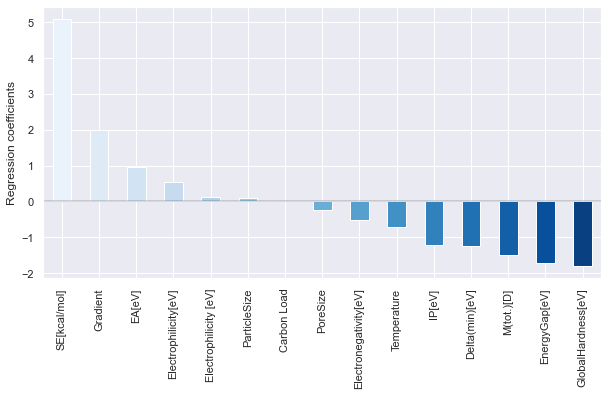

In [16]:
# PLS Coefficient Plot
Visualizer.coefficient_plot(
    coefficients=_pls_optimal_model.named_steps["plsregression"].coef_,
    column_names=np.array(list(_data_df.drop(columns=["TR"])))
)

In [17]:
display(_pls_predictions_df)
display(_pls_metrics_df)

,0
r2_train,0.800457
rmse_train,3.213529
r2_validation,0.782839
rmse_validation,3.384593
r2_bt,0.807956
rmse_bt,3.630586


,y,y_hat,residuals,train_test,leverage,scaled_residuals
0,24.892,25.099103,0.207103,Train,0.093937,0.064447
1,17.206,15.018946,-2.187054,Train,0.060857,-0.680577
2,11.315,16.389090,5.074090,Train,0.087276,1.578977
3,31.065,22.426716,-8.638284,Train,0.080276,-2.688099
4,14.532,15.372299,0.840299,Train,0.045973,0.261488
...,...,...,...,...,...,...
355,4.968,6.809410,1.841410,BT,0.066822,0.573018
356,22.754,20.321756,-2.432244,BT,0.045584,-0.756876
357,10.271,9.311211,-0.959789,BT,0.077291,-0.298671
358,8.110,10.383826,2.273826,BT,0.097336,0.707579


## Gradient Boosting Regression
---

In [18]:
# GB parameter grid
_gb_param_grid = {
    'n_estimators': np.arange(10, 210, 10),
    'learning_rate':[.001, 0.01, .1],
    'max_features': [None, 'sqrt'],
    'max_depth': range(1, 6, 1),
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 3, 5],
}

In [19]:
# Instantiate GB model
_gb_model = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=12345),
    param_grid=_gb_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=ps,
    n_jobs=6,
    verbose=1
)

In [20]:
# Fit model
_gb_model.fit(
    deepcopy(_x_train_all),  # Use all, because we extracted the validation indices previously for reproducibility
    deepcopy(_y_train_all.ravel())   # Use all, because we extracted the validation indices previously for reproducibility
)

Fitting 1 folds for each of 5400 candidates, totalling 5400 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=GradientBoostingRegressor(random_state=12345), n_jobs=6,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': range(1, 6),
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
             scoring='neg_root_mean_squared_error', verbose=1)

In [21]:
# Optimal Results
print(f"Optimal hyper-parameters : {_gb_model.best_params_}")
print(f"Optimal RMSE : {-_gb_model.best_score_.round(3)}")

# Optimal Model
_gb_optimal_model: GradientBoostingRegressor = _gb_model.best_estimator_

display(_gb_optimal_model)

Optimal hyper-parameters : {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Optimal RMSE : 0.205


GradientBoostingRegressor(max_depth=4, max_features='sqrt', min_samples_split=5,
                          n_estimators=200, random_state=12345)

Results Analysis for : Gradient Boosting


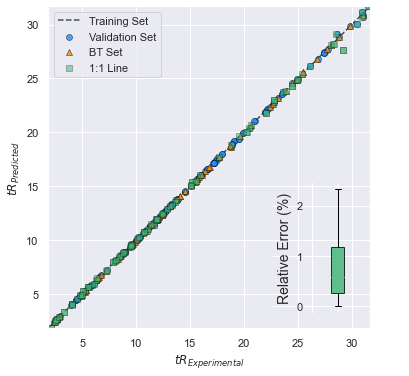

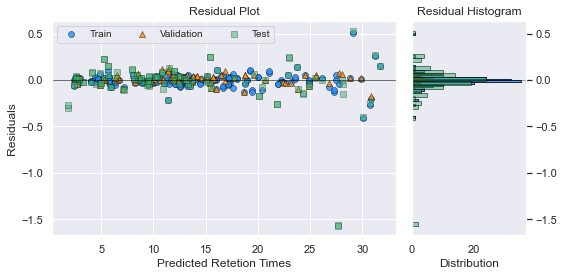

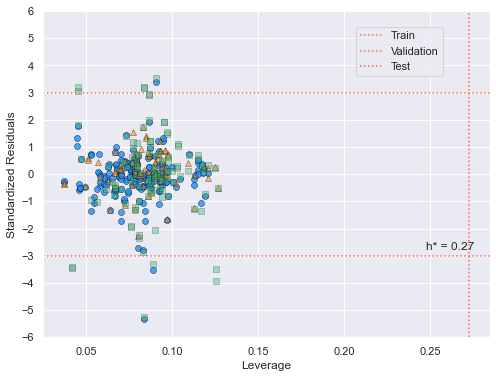

Average score after 1000 iteration: 9.098257878023952


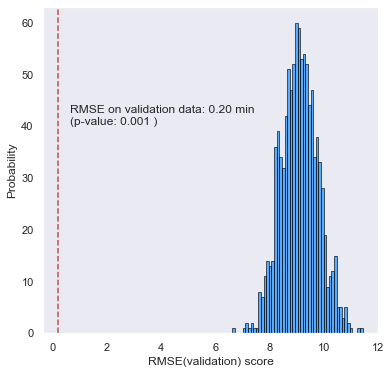

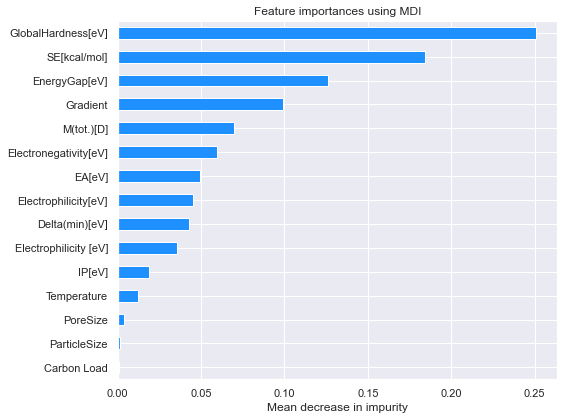

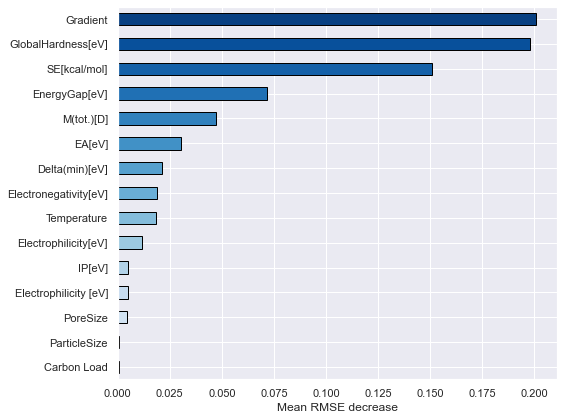

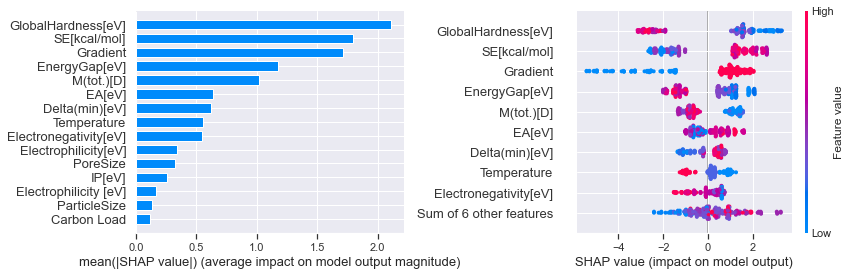

In [22]:
# Analyze results
_gb_predictions_df, _gb_metrics_df = analyze_model(
    model=_gb_optimal_model,
    cv=ps,
    title="Gradient Boosting",
    x_train=deepcopy(_x_train),
    y_train=deepcopy(_y_train.ravel()),
    x_validation=deepcopy(_x_validation),
    y_validation=deepcopy(_y_validation.ravel()),
    x_bt=deepcopy(_x_bt),
    y_bt=deepcopy(_y_bt.ravel()),
    x_train_all=deepcopy(_x_train_all),
    y_train_all=deepcopy(_y_train_all.ravel()),
    x_all=deepcopy(_x),
    y_all=deepcopy(_y.ravel()),
    column_names=np.array(list(_data_df.drop(columns=["TR"]).columns)),
    b_plot_y_randomization=True
)

In [23]:
display(_gb_predictions_df)
display(_gb_metrics_df)

,0
r2_train,0.999887
rmse_train,0.076488
r2_validation,0.999944
rmse_validation,0.054447
r2_bt,0.999103
rmse_bt,0.248095


,y,y_hat,residuals,train_test,leverage,scaled_residuals
0,24.892,24.883371,-0.008629,Train,0.093937,-0.113048
1,17.206,17.199645,-0.006355,Train,0.060857,-0.083247
2,11.315,11.294151,-0.020849,Train,0.087276,-0.273127
3,31.065,30.856445,-0.208555,Train,0.080276,-2.732100
4,14.532,14.503249,-0.028751,Train,0.045973,-0.376640
...,...,...,...,...,...,...
355,4.968,4.937499,-0.030501,BT,0.066822,-0.399569
356,22.754,22.998606,0.244606,BT,0.045584,3.204382
357,10.271,10.301673,0.030673,BT,0.077291,0.401824
358,8.110,8.117889,0.007889,BT,0.097336,0.103352


## Ridge Regression
---

In [24]:
# Optimize the regularization parameter (alpha)
_ridge_model = make_pipeline(
    StandardScaler(),
    RidgeCV(
        alphas=[0.01, 0.1, 1, 10, 50, 100, 200],
        scoring= 'neg_root_mean_squared_error',
        cv=ps
    )
)

In [25]:
_ridge_model.fit(
    X=deepcopy(_x_train_all),
    y=deepcopy(_y_train_all.ravel())
)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 5.e+01, 1.e+02, 2.e+02]),
                         cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
                         scoring='neg_root_mean_squared_error'))])

In [26]:
# Display Optimal Results
print('Optimal alpha :',  _ridge_model.named_steps['ridgecv'].alpha_)
print('Optimal RMSE : ',  -_ridge_model.named_steps['ridgecv'].best_score_)

Optimal alpha : 0.01
Optimal RMSE :  3.095967643129059


Results Analysis for : Ridge Regression


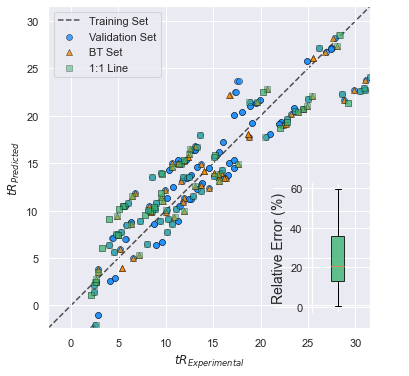

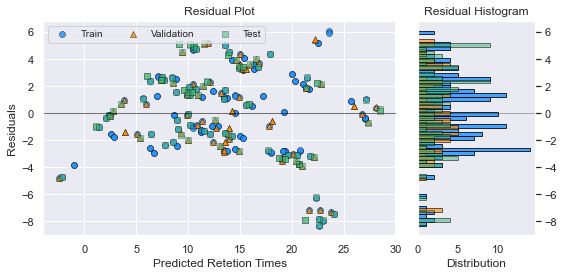

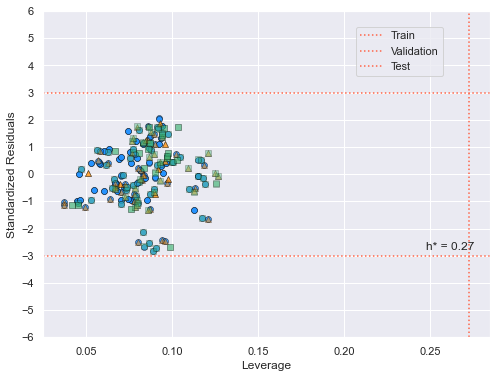

In [27]:
# Analyze results
_ridge_predictions_df, _ridge_metrics_df = analyze_model(
    model=_ridge_model,
    cv=ps,
    title="Ridge Regression",
    x_train=deepcopy(_x_train),
    y_train=deepcopy(_y_train.ravel()),
    x_validation=deepcopy(_x_validation),
    y_validation=deepcopy(_y_validation.ravel()),
    x_bt=deepcopy(_x_bt),
    y_bt=deepcopy(_y_bt.ravel()),
    x_train_all=deepcopy(_x_train_all),
    y_train_all=deepcopy(_y_train_all.ravel()),
    x_all=deepcopy(_x),
    y_all=deepcopy(_y.ravel()),
    column_names=np.array(list(_data_df.drop(columns=["TR"]).columns)),
    b_plot_feature_importances=False
)

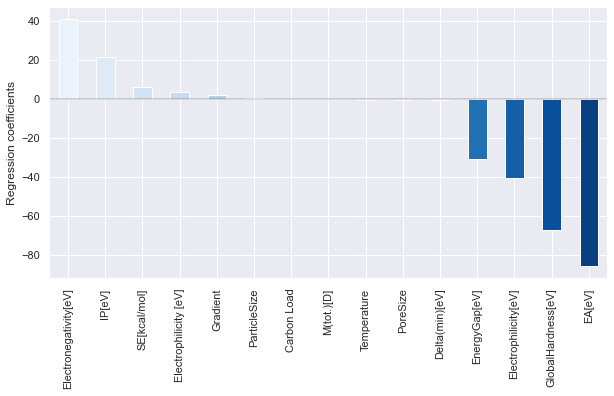

In [28]:
# Ridge Coefficient Plot
Visualizer.coefficient_plot(
    coefficients=_ridge_model.named_steps["ridgecv"].coef_,
    column_names=np.array(list(_data_df.drop(columns=["TR"])))
)

In [29]:
display(_ridge_predictions_df)
display(_ridge_metrics_df)

,0
r2_train,0.833273
rmse_train,2.937428
r2_validation,0.834331
rmse_validation,2.956210
r2_bt,0.834966
rmse_bt,3.365607


,y,y_hat,residuals,train_test,leverage,scaled_residuals
0,24.892,25.749857,0.857857,Train,0.093937,0.292048
1,17.206,15.348391,-1.857609,Train,0.060857,-0.632402
2,11.315,15.386738,4.071738,Train,0.087276,1.386177
3,31.065,23.745330,-7.319670,Train,0.080276,-2.491898
4,14.532,14.520842,-0.011158,Train,0.045973,-0.003799
...,...,...,...,...,...,...
355,4.968,7.434130,2.466130,BT,0.066822,0.839566
356,22.754,19.391295,-3.362705,BT,0.045584,-1.144795
357,10.271,9.070459,-1.200541,BT,0.077291,-0.408711
358,8.110,10.076650,1.966650,BT,0.097336,0.669524


# Stack of Models

In [70]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression

In [76]:
class StackingRegressor(BaseEstimator):
    
    def __init__(self, *models):
        self.models: List[Any] = models
        self.__stack_model: LinearRegression = LinearRegression()
        self.IS_FITTED: bool = False
            
    def __initial_predict(self, X) -> ndarray:
        return np.hstack(
            [_model.predict(X).reshape(-1, 1) for _model in self.models]
        )
            
    def fit(self, X, y):
        _x = self.__initial_predict(X)
        self.__stack_model.fit(_x, y)
        self.IS_FITTED = True
    
    def predict(self, X) -> ndarray:
        _x = self.__initial_predict(X)
        return self.__stack_model.predict(_x).reshape(-1, 1)


In [90]:
class EnsembleRegressor:
    
    def __init__(self, *models):
        self.models: List[Any] = models
            
    def __initial_predict(self, X) -> ndarray:
        return np.hstack(
            [_model.predict(X).reshape(-1, 1) for _model in self.models]
        )
    
    def predict(self, X) -> ndarray:
        _x = self.__initial_predict(X)
        return np.mean(_x, axis=1).reshape(-1, 1)


In [77]:
_stack_regressor = StackingRegressor(
    _rfs_model,
    _gb_model,
    _pls_optimal_model,
    _ridge_model
)

In [78]:
_stack_regressor.fit(
    _x_train_all,
    _y_train_all
)

Results Analysis for : Stack Regressor


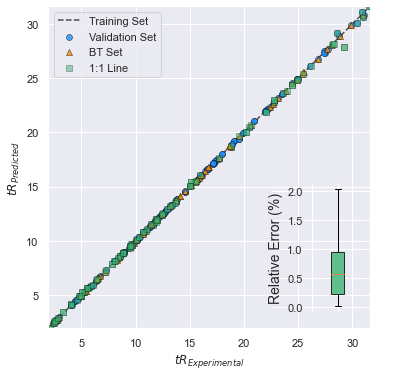

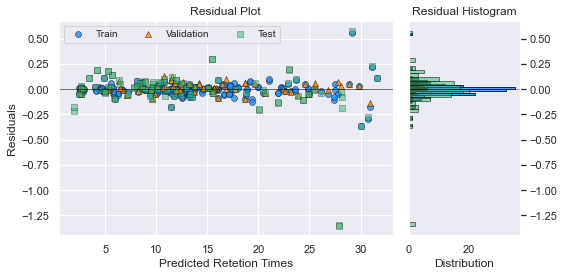

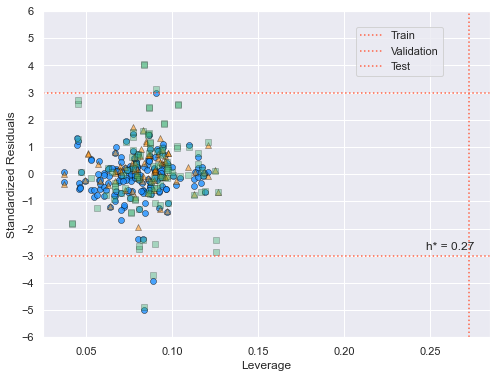

In [83]:
# Analyze results
_stack_metrics_df, _stack_predictions_df = analyze_model(
    model=_stack_regressor,
    cv=ps,
    title="Stack Regressor",
    x_train=deepcopy(_x_train),
    y_train=deepcopy(_y_train.ravel()),
    x_validation=deepcopy(_x_validation),
    y_validation=deepcopy(_y_validation.ravel()),
    x_bt=deepcopy(_x_bt),
    y_bt=deepcopy(_y_bt.ravel()),
    x_train_all=deepcopy(_x_train_all),
    y_train_all=deepcopy(_y_train_all.ravel()),
    x_all=deepcopy(_x),
    y_all=deepcopy(_y.ravel()),
    column_names=np.array(list(_data_df.drop(columns=["TR"]).columns)),
    b_plot_feature_importances=False
)

In [85]:
_stack_metrics_df

,0
r2_train,0.999894
rmse_train,0.074100
r2_validation,0.999953
rmse_validation,0.049631
r2_bt,0.999297
rmse_bt,0.219669


In [84]:
_stack_predictions_df

,y,y_hat,residuals,train_test,leverage,scaled_residuals
0,24.892,24.895603,0.003603,Train,0.093937,0.048729
1,17.206,17.208699,0.002699,Train,0.060857,0.036499
2,11.315,11.283579,-0.031421,Train,0.087276,-0.424968
3,31.065,30.887671,-0.177329,Train,0.080276,-2.398381
4,14.532,14.508508,-0.023492,Train,0.045973,-0.317732
...,...,...,...,...,...,...
355,4.968,4.935861,-0.032139,BT,0.066822,-0.434677
356,22.754,22.957223,0.203223,BT,0.045584,2.748593
357,10.271,10.336986,0.065986,BT,0.077291,0.892467
358,8.110,8.142885,0.032885,BT,0.097336,0.444767


# Average Ensemble Regressor

In [91]:
_avrg_regressor = EnsembleRegressor(
    _rfs_model,
    _gb_model,
    _pls_optimal_model,
    _ridge_model
)

Results Analysis for : Avrg Ensemble Regressor


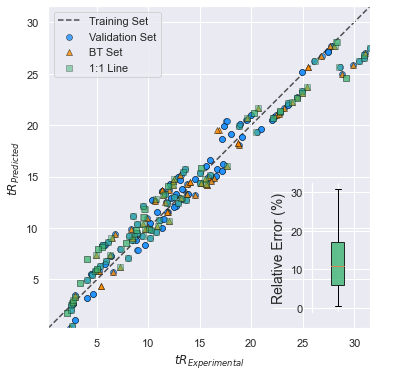

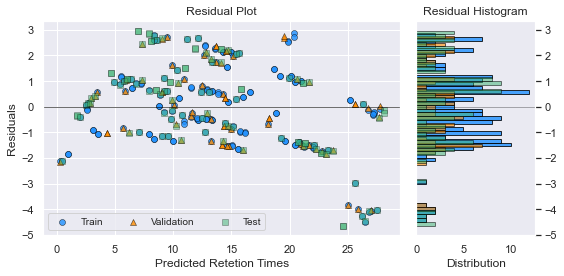

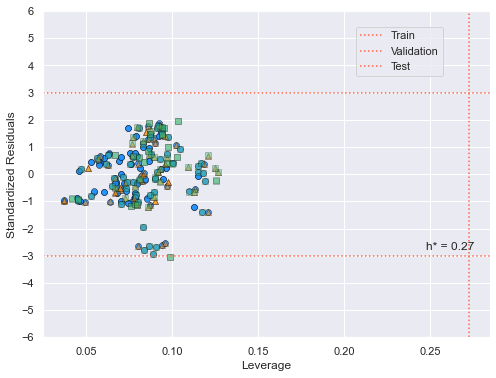

In [92]:
# Analyze results
_avrg_metrics_df, _avrg_predictions_df = analyze_model(
    model=_avrg_regressor,
    cv=ps,
    title="Avrg Ensemble Regressor",
    x_train=deepcopy(_x_train),
    y_train=deepcopy(_y_train.ravel()),
    x_validation=deepcopy(_x_validation),
    y_validation=deepcopy(_y_validation.ravel()),
    x_bt=deepcopy(_x_bt),
    y_bt=deepcopy(_y_bt.ravel()),
    x_train_all=deepcopy(_x_train_all),
    y_train_all=deepcopy(_y_train_all.ravel()),
    x_all=deepcopy(_x),
    y_all=deepcopy(_y.ravel()),
    column_names=np.array(list(_data_df.drop(columns=["TR"]).columns)),
    b_plot_feature_importances=False
)

In [93]:
_avrg_metrics_df

,0
r2_train,0.954752
rmse_train,1.530259
r2_validation,0.952430
rmse_validation,1.584099
r2_bt,0.953675
rmse_bt,1.783132


In [94]:
_avrg_predictions_df

,y,y_hat,residuals,train_test,leverage,scaled_residuals
0,24.892,25.166313,0.274313,Train,0.093937,0.179260
1,17.206,16.201649,-1.004351,Train,0.060857,-0.656332
2,11.315,13.583115,2.268115,Train,0.087276,1.482187
3,31.065,26.995803,-4.069197,Train,0.080276,-2.659172
4,14.532,14.733336,0.201336,Train,0.045973,0.131571
...,...,...,...,...,...,...
355,4.968,6.043149,1.075149,BT,0.066822,0.702597
356,22.754,21.339707,-1.414293,BT,0.045584,-0.924224
357,10.271,9.809410,-0.461590,BT,0.077291,-0.301644
358,8.110,9.227692,1.117692,BT,0.097336,0.730399
